In [0]:
#!pip install tqdm pymc3 theano

In [1]:
%matplotlib inline
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.transforms import t_stick_breaking

/Users/ded/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7201 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:86:00.0)
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
N = 1000 # seen annimals
S = 100 # sample periods

In [3]:
#arrivals
#birth = torch.cat((torch.tensor([.5]), torch.zeros(S-1) + 0.1), 0) 
birth_init = np.concatenate(([40], np.zeros(S-1)+((100-40)/(S-1))), axis=0)
arr = pm.Dirichlet.dist(birth_init).random()
birth_init = np.concatenate(([.4], np.ones(S-1) * (1-.4)/(S-1)), axis=0)

#departure
dep  = np.concatenate((np.ones(S-1) * .2, [1.]), axis=0)

# Capture probability
prop = pm.Beta.dist(.25, 5).random(size = N)

In [4]:
birth_init, dep

(array([0.4       , 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00

In [6]:
CH = []
GCH = []
# Generate the data
Arrival_DIST = pm.Categorical.dist(birth_init)

for i in tqdm(range(N)):
#for i in range(N):
    arrival = Arrival_DIST.random()
    dep_tmp = dep.copy()
    dep_tmp[:arrival] = 0
    #print(arrival)
    #print(dep_tmp)
    dep_tmp = np.append([1],(1-dep_tmp).cumprod())[:-1] * dep_tmp
    #print(dep_tmp)
    departure = pm.Categorical.dist(dep_tmp).random() 
    #print(departure)
    dur = departure - arrival + 1
    capture_history = pm.Bernoulli.dist(prop[i]).random(size=(dur,1))
    capture_history = np.concatenate((np.zeros(arrival), 
                                      np.array(capture_history), 
                                      np.zeros(S - departure - 1)), 
                                     axis = 0)
    if capture_history.any():
        #print(arrival, departure, dur, "proba:", prop[i])
        #print(capture_history)
        first = capture_history.argmax()
        last = S - capture_history[::-1].argmax() -1
        count = capture_history.sum()
        GCH.append([first, last, count])
        CH.append(capture_history)

100%|██████████| 1000/1000 [00:27<00:00, 36.27it/s]


In [7]:
import pickle
with open('gch.pkl', 'wb') as f:
  pickle.dump(GCH, f)

In [5]:
import pickle
with open('gch.pkl', 'rb') as f:
  GCH = pickle.load(f)

In [6]:
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V, type(V)

(133, int)

In [7]:
def get_vmask():
    v_mask = np.zeros([S,S,S])
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            v_mask[s,q]= np.concatenate((c1, c2, c3))
    return tt.constant(v_mask)

In [8]:
def get_imask():
    s_mask = np.zeros([V,S])
    q_mask = np.zeros([V,S])
    for w in np.arange(V):
        f, l = npdata[w, 0] , npdata[w, 1]
        s_mask[w] = np.concatenate((np.ones(f+1), np.zeros(S - f -1)))
        q_mask[w] = np.concatenate((np.zeros(l), np.ones(S-l)))
    i_mask = np.einsum("is,iq->isq", s_mask, q_mask)
    return tt.constant(i_mask)

In [9]:
def get_Risq(a,b):
    tmp_u = npdata[:, 2]
    expanded_u = tmp_u[:, np.newaxis, np.newaxis] *  np.ones((V, S, S)) # V x S x S
    d = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (V, S, S)) # V x S x S
    n = tt.constant(np.clip(d,a_min=0,a_max=S+1))
    n_u = np.triu(d - expanded_u, 0)
    n_u = tt.constant(np.clip(n_u,a_min=0,a_max=max(tmp_u))) # V x S x S
   
    
    # The beta binomial
    R_isq =   tt.gammaln(n+1)
    R_isq -=  tt.gammaln(expanded_u+1)
    R_isq -=  tt.gammaln(n_u+1)   
    R_isq +=  tt.gammaln(expanded_u+a)
    R_isq +=  tt.gammaln(n_u+b)
    R_isq -=  tt.gammaln(n+a+b)
    R_isq +=  tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)

    # The above is the computation of the log, so we take the exponent
    return tt.exp(R_isq)

In [10]:
def get_Risq0(a,b):
    # n = q - s + 1
    n = tt.constant(np.triu(np.ones([S,S]), 0).cumsum(axis =1))
    R0_sq = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    return tt.exp(R0_sq)

In [11]:
def logp_capture(arr, phi, a, b, U, phi_mask, i_mask, R_isq, R0_sq):
    def ll_capture_f(mycaptures):
        # Build masks
        #phi_mask = get_vmask()  # S x S x S . all possible arrivals and departures for the "SURVIVAL"
        #i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
        #R_isq = get_Risq(a, b) #
        #R0_sq = get_Risq0(a, b) #
        
        # Computation
        phi_v = tt.pow(1-phi, phi_mask)
        phi_v = tt.prod(phi_v, axis=2)
        #LD    = tt.einsum('s,sq,q->sq', A, phi_v, phi)
        LD = arr[:, np.newaxis] * phi_v * phi
        #LD_isq = tf.einsum('sq,isq->isq', LD, i_mask)
        #i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
        LD_isq = tt.mul(LD, i_mask) #
        
        #R_isq = get_Risq(a, b) #
        
        Li = tt.batched_tensordot(LD_isq, R_isq, axes = 2) #
        
        # Likelihood of Not Capture
        v0_mask = 1 - phi_mask[0] # tihs is reuse
        LD0 = tt.mul(LD, v0_mask) #
        
        #R0_sq = get_Risq0(a,b) #
        
        L0 = tt.sum(LD0 * R0_sq) #
        
        # Putting it together
        obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0) - tt.gammaln(tt.constant(V)+ 1.0) #
        obj2 = tt.sum(tt.log(Li)) #
        obj3 = U * tt.log(L0) #

        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [13]:
for UU in range(1500, 4000, 100):
    print(UU, ":", logp_capture(birth_init, dep, .04, 2.6, UU)(npdata).eval())

1500 : -644.4279869764341
1600 : -638.789335608481
1700 : -633.7170904905278
1800 : -629.1477750600747
1900 : -625.0296315046215
2000 : -621.3177379491684
2100 : -617.9759615812153
2200 : -614.9681695882622
2300 : -612.2670182203091
2400 : -609.847116852356
2500 : -607.6860045469028
2600 : -605.7661031789497
2700 : -604.0669049359966
2800 : -602.5727848180435
2900 : -601.2720240750904
3000 : -600.1509508321373
3100 : -599.1939400891841
3200 : -598.397085596231
3300 : -597.7486686032779
3400 : -597.2389234853248
3500 : -596.8600377423717
3600 : -596.6081051244186
3700 : -596.4694537564654
3800 : -596.4440836385123
3900 : -596.5241822705592


In [12]:
# custom log-liklihood
# model
with pm.Model() as model:
    # Hyper Params
    U = pm.DiscreteUniform('Unseen', lower=V, upper=5000)
    a = pm.Uniform('alpha', 0., 1.)
    b  = pm.Uniform('beta', 2, 10)
    #alpha1 = pm.Uniform('alphaphi', 0, 100)
    #beta1  = pm.Uniform('betaphi',  0, 100)
    # Capture, Departure, Arrival probability
    # prop   = pm.Beta('propensity', alpha=alpha0, beta=beta0, shape=(V))
    #phi    = pm.Beta('survival',   alpha=alpha1, beta=beta1, shape=S)
    phi    = pm.Uniform('departure', 0., 1., shape=S)
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    # Masks
    phi_mask = get_vmask()  # S x S x S . all possible arrivals and departures for the "SURVIVAL"
    i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
    R_isq = get_Risq(a, b) #
    R0_sq = get_Risq0(a, b) #
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U, phi_mask, i_mask, R_isq, R0_sq), observed=npdata)
    #MAP = pm.find_MAP()

In [ ]:
with model:
  #posterior = pm.sample(3, tune=0, chains=1, progressbar=False)
  #step = pm.NUTS()
  #posterior = pm.sample(100000, step=step, njobs = 4)
  posterior = pm.sample(1000, cores = 1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [Unseen]
>NUTS: [arrival, departure, beta, alpha]
 69%|██████▉   | 1037/1500 [1:00:15<26:54,  3.49s/it]

In [0]:
#pm.find_MAP(model = model)

In [0]:
#test = [ob.logp(i) for i in posterior]


In [0]:
#counter = 0
#for i in posterior:
#  counter += 1
#  if counter % 500 == 0:
#    print(ob.logp(i))

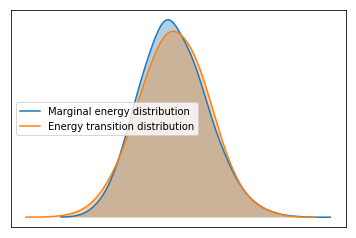

In [0]:
pm.energyplot(posterior);

In [0]:
#pm.plot_posterior(posterior, lw=0, alpha=0.5);


ValueError: ignored

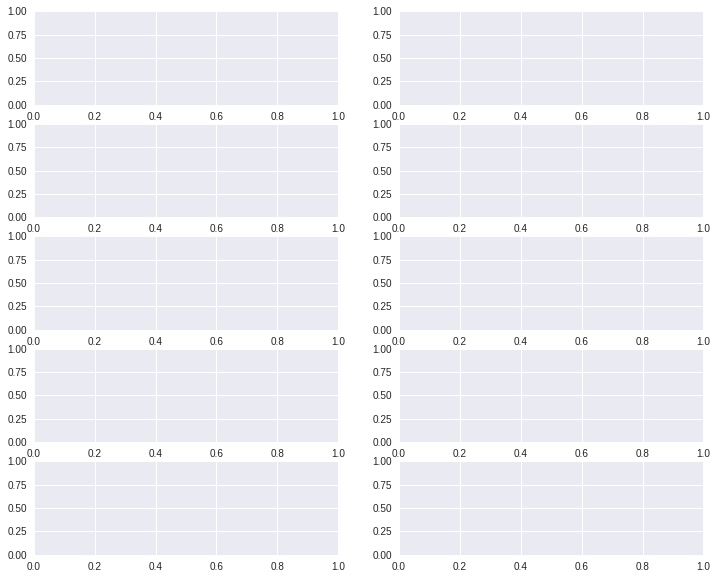

In [17]:
pm.traceplot(posterior);

In [18]:
pm.summary(posterior).round(2)

ValueError: ignored

In [0]:
counter = 0
for i in posterior:
  counter += 1
  if counter % 500 == 0:
    print(ob.logp(i))

-405.28831039124634
-406.12692569050705
-403.7145354717504
-405.53096528106835
-409.06818119547097
-407.19463991431985
-405.2279709104041
-407.1482822879334
-406.5397125444142
-404.45332830562256


In [0]:
np.array([1./S]*S)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [0]:
birth_init

array([0.4       , 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667])

In [0]:
arr

arrival

In [0]:
dep

array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.4       ])

In [0]:
xx = np.array([Arrival_DIST.random() for x in range(1000)])

In [0]:
u, c = np.unique(xx, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([108, 108, 106, 104, 106,  96,  94,  92,  94,  92]))

In [0]:
np.array([1./S]*S)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [0]:
pm.Bernoulli.dist(0.096).random(size=(10,1))[-1]

0

In [0]:
prop.sort()

In [0]:
count = 0
for i in range(1000):
    k = pm.Bernoulli.dist(prop[i]).random(size=10)
    if k.any():
        count +=1
        print(i, k)
print(count)

5 [0 0 0 0 0 1 0 0 0 0]
7 [0 0 0 0 0 0 0 1 0 0]
17 [0 0 0 0 0 0 1 0 0 0]
20 [0 0 0 0 0 0 0 1 1 0]
23 [0 0 0 0 1 0 0 0 0 0]
32 [0 0 0 0 0 0 0 1 0 0]
35 [0 0 0 0 0 0 0 0 1 0]
36 [0 0 1 0 1 0 0 0 0 0]
40 [1 0 0 0 0 0 0 0 0 0]
48 [0 0 0 0 0 1 0 0 0 0]
57 [0 0 0 0 0 0 1 1 0 0]
59 [0 0 0 0 0 0 0 0 0 1]
62 [0 0 0 0 1 0 0 0 0 0]
63 [0 0 1 0 0 0 0 0 0 0]
64 [0 1 0 0 0 1 0 1 0 0]
66 [0 0 0 0 0 0 0 0 1 0]
67 [0 0 0 1 0 1 0 0 1 0]
71 [0 0 0 0 1 0 0 0 0 1]
80 [1 0 0 0 0 0 0 0 0 0]
81 [0 1 0 0 0 0 0 0 0 0]
84 [0 1 1 0 0 0 0 0 0 0]
98 [0 0 0 0 0 0 1 0 0 0]
113 [0 0 0 0 0 0 0 1 0 0]
119 [0 1 0 0 0 0 0 0 0 0]
133 [1 0 0 0 0 0 0 0 0 0]
134 [1 0 0 0 0 0 0 0 0 0]
138 [0 0 0 0 0 0 0 0 0 1]
152 [0 0 0 0 0 0 0 1 0 0]
153 [0 1 1 0 0 1 1 0 0 0]
154 [0 0 0 0 0 0 0 0 1 0]
158 [0 1 0 0 0 0 1 0 0 0]
165 [0 0 0 0 0 0 0 0 1 0]
170 [0 1 0 0 0 0 0 0 0 0]
179 [0 0 0 0 0 0 0 0 1 0]
181 [0 1 0 0 0 0 0 0 0 0]
184 [0 0 0 0 0 0 0 1 0 0]
192 [1 0 0 0 0 0 0 0 0 0]
193 [0 0 0 0 0 0 0 0 0 1]
203 [0 0 0 0 0 0 0 1 0 0]
204 [0 0 1

In [0]:
count = 0
for i in range(1000):
    k = scipy.stats.bernoulli(prop[i]).rvs(10)
    if k.any():
        count +=1
        print(i, k)
print(count)

2 [0 0 0 0 0 0 0 1 0 0]
11 [0 0 0 0 0 0 1 0 0 0]
17 [1 1 0 0 0 0 0 0 0 0]
35 [0 1 0 0 0 0 0 0 0 0]
36 [0 1 0 1 1 0 0 0 0 1]
43 [0 0 0 0 0 0 0 0 0 1]
46 [0 0 0 0 0 0 0 0 0 1]
62 [0 0 0 0 0 0 0 0 0 1]
63 [0 0 0 0 0 0 1 0 0 0]
67 [0 1 0 0 0 0 0 0 1 0]
68 [0 0 0 0 0 1 0 0 0 0]
71 [0 0 0 0 0 0 1 0 0 0]
84 [0 0 0 0 1 0 0 0 0 0]
86 [1 0 0 0 0 0 0 0 0 0]
104 [0 0 0 0 0 1 0 0 0 0]
109 [0 0 0 1 0 0 0 0 0 0]
113 [0 0 0 0 0 0 0 0 1 0]
116 [0 0 0 0 1 0 0 0 0 0]
126 [0 0 0 0 1 0 0 0 0 0]
130 [0 1 0 0 0 0 0 0 0 0]
136 [0 0 0 1 0 0 0 0 0 0]
137 [0 0 0 0 0 0 1 0 0 0]
153 [0 0 1 0 1 0 0 0 0 1]
154 [1 1 0 1 0 0 0 0 0 0]
165 [0 0 0 0 0 1 0 0 1 0]
169 [0 0 0 0 0 0 0 1 0 0]
170 [0 1 0 0 0 0 0 0 0 0]
183 [0 0 0 0 0 0 0 0 1 0]
184 [0 0 1 0 0 0 0 0 0 0]
186 [0 0 0 1 0 0 0 0 0 0]
203 [1 0 0 0 0 0 0 0 0 0]
204 [0 0 0 1 0 0 0 0 0 1]
208 [0 0 0 1 0 0 0 0 0 0]
225 [0 0 1 0 0 0 0 0 0 0]
230 [0 0 0 1 0 0 0 0 0 0]
237 [0 0 0 0 0 0 0 0 1 0]
243 [0 1 0 0 0 0 0 0 0 0]
248 [0 0 0 0 0 0 1 0 0 0]
249 [0 0 0 0 0 0 0 1 0 0]
2

In [0]:
scipy.stats.bernoulli(0.1619882271737661).rvs(9)

array([0, 1, 0, 0, 0, 0, 0, 0, 1])

In [0]:
prop.sort()
prop.round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001,

In [0]:
np.set_printoptions(suppress=True)

In [0]:
CH[10:20]

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 